In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [55]:
# PARAMETERS
NUM_STEPS = 500
DT = 1.0 / NUM_STEPS
BATCH_SIZE = 128
ITERS = 100
LAMBDA_REG = 0.05 # Regularization weight for control effort (NOTE: experiments reproducibility may vary with this parameter)

In [56]:
# The Experts (or the pretrained drifts)
def drift_center(x):
    # Ornstein-Uhlenbeck process pulling to (0,0)
    return -1.0 * x 

In [58]:
class ControlNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2+1, 64), # Input: drift (2D) + time (1D)
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

In [59]:
ctrl1 = ControlNet2D()
ctrl2 = ControlNet2D()
ctrl_list = [ctrl1, ctrl2]

opt1 = optim.Adam(ctrl1.parameters(), lr=0.005)
opt2 = optim.Adam(ctrl2.parameters(), lr=0.005)
target_dist = 4.0

def simulate(ctrl_list, player_idx):
    """
    Simulate one trajectory. Only player_idx's control participates in autograd.
    """
    ctrl1, ctrl2 = ctrl_list

    x1 = torch.randn(BATCH_SIZE, 2)
    x2 = torch.randn(BATCH_SIZE, 2)

    control_cost = 0.0
    running_cost = 0.0

    for i in range(NUM_STEPS):
        t_val = i * DT
        t_tensor = torch.full((BATCH_SIZE, 1), t_val)

        if player_idx == 0:
            # player 0 learns, player 1 is fixed
            u1 = ctrl1(x1, t_tensor)           # grad flows
            with torch.no_grad():
                u2 = ctrl2(x2, t_tensor)       # fixed
        else:
            # player 1 learns, player 0 is fixed
            with torch.no_grad():
                u1 = ctrl1(x1, t_tensor)       # fixed
            u2 = ctrl2(x2, t_tensor)           # grad flows

        b1 = drift_center(x1)
        b2 = drift_center(x2)

        noise1 = torch.randn_like(x1) * np.sqrt(DT)
        noise2 = torch.randn_like(x2) * np.sqrt(DT)

        x1 = x1 + (b1 + u1) * DT + noise1
        x2 = x2 + (b2 + u2) * DT + noise2

        control_cost = control_cost + torch.mean(u1**2 + u2**2) * DT
        running_cost = running_cost + torch.mean(
            torch.norm(x1 - x2, p=2, dim=1) - target_dist
        ) * DT

    # terminal cost
    dist = torch.norm(x1 - x2, p=2, dim=1)
    geo_loss = torch.mean((dist - target_dist)**2)

    loss = geo_loss + LAMBDA_REG * control_cost + running_cost
    return loss, geo_loss


print("Starting training...")
loss_history = []

for epoch in range(ITERS):

    # ----- update player 0 given player 1 fixed -----
    opt1.zero_grad()
    loss1, geo1 = simulate(ctrl_list, player_idx=0)
    loss1.backward()
    opt1.step()

    # ----- update player 1 given player 0 fixed -----
    opt2.zero_grad()
    loss2, geo2 = simulate(ctrl_list, player_idx=1)
    loss2.backward()
    opt2.step()

    loss_history.append((loss1.item(), loss2.item()))
    if epoch % 1 == 0:
        print(
            f"Epoch {epoch}: "
            f"Loss1 {loss1.item():.4f} (DistErr1 {geo1.item():.4f})  |  "
            f"Loss2 {loss2.item():.4f} (DistErr2 {geo2.item():.4f})", 
            end='\r'
        )

print("\n--- Training Complete ---")

Starting training...
Epoch 99: Loss1 -1.2813 (DistErr1 0.3514)  |  Loss2 -1.3042 (DistErr2 0.3414)
--- Training Complete ---


In [60]:
def generate_trajectories(n_pairs: int = 10):
    ctrl1.eval()
    ctrl2.eval()
    with torch.no_grad():
        x1 = torch.randn(n_pairs, 2)
        x2 = torch.randn(n_pairs, 2)
        
        # Store trajectories for plotting
        traj_x1 = np.zeros((n_pairs, NUM_STEPS+1, 2))
        traj_x2 = np.zeros((n_pairs, NUM_STEPS+1, 2))
        
        traj_x1[:, 0, :] = x1.numpy()
        traj_x2[:, 0, :] = x2.numpy()
        
        for i in range(NUM_STEPS):
            t_scalar = i * DT   
            t_tensor = torch.full((n_pairs, 1), t_scalar)
            
            u1 = ctrl1(x1, t_tensor)
            u2 = ctrl2(x2, t_tensor)
            
            x1 = x1 + (drift_center(x1) + u1) * DT 
            x2 = x2 + (drift_center(x2) + u2) * DT 
            
            traj_x1[:, i+1, :] = x1.numpy()
            traj_x2[:, i+1, :] = x2.numpy()

            
    return traj_x1, traj_x2
# Generate Data
print("Generating uncontrolled paths...")
traj_x1, traj_x2 = generate_trajectories()

Generating uncontrolled paths...


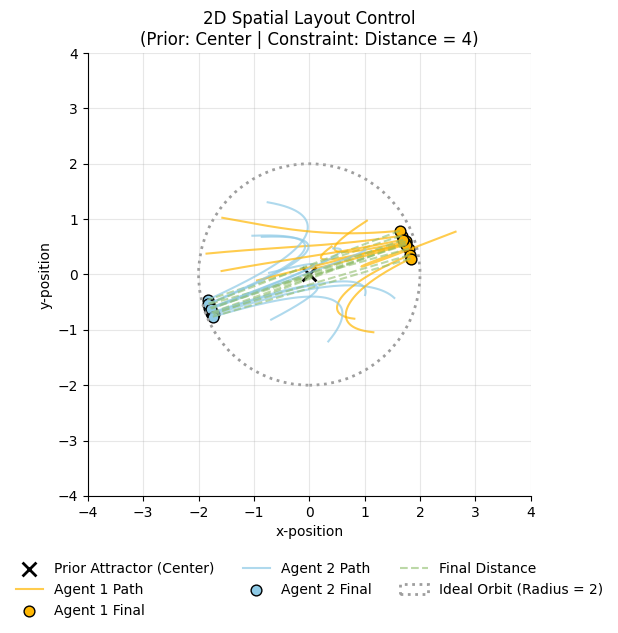

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.set_title("2D Spatial Layout Control\n(Prior: Center | Constraint: Distance = 4)")

# Pastel colors
color_a1 = "#ffb703"  # Agent 1 (orange)
color_a2 = "#8ecae6"  # Agent 2 (blue)
color_conn = "#90be6d"  # soft green for connections
color_ring = "#9e9e9e"  # grey for orbit

center = ax.scatter(0, 0, c="black", marker="x", s=100, linewidths=2)
path1 = path2 = final1 = final2 = conn_line = None

# Trajectories
n_agents = traj_x1.shape[0]
for k in range(n_agents):
    # Agent 1
    p1, = ax.plot(traj_x1[k, :, 0], traj_x1[k, :, 1],
                  c=color_a1, alpha=0.7, linewidth=1.5)
    f1 = ax.scatter(traj_x1[k, -1, 0], traj_x1[k, -1, 1],
                    c=color_a1, edgecolors="black", s=60)

    # Agent 2
    p2, = ax.plot(traj_x2[k, :, 0], traj_x2[k, :, 1],
                  c=color_a2, alpha=0.7, linewidth=1.5)
    f2 = ax.scatter(traj_x2[k, -1, 0], traj_x2[k, -1, 1],
                    c=color_a2, edgecolors="black", s=60)

    # Connection between final positions
    c_line, = ax.plot(
        [traj_x1[k, -1, 0], traj_x2[k, -1, 0]],
        [traj_x1[k, -1, 1], traj_x2[k, -1, 1]],
        c=color_conn, linestyle="--", alpha=0.6, linewidth=1.5
    )

    # save only once for legend
    if k == 0:
        path1, final1, path2, final2, conn_line = p1, f1, p2, f2, c_line

# Target ring (ideal orbit)
circle = plt.Circle((0, 0), 2.0, edgecolor=color_ring,
                    fill=False, linestyle=":", linewidth=2)
ax.add_patch(circle)

# Axes settings
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect("equal", "box")
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")

# Grid & spines
ax.grid(True, alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend at bottom
ax.legend(
    [center, path1, final1, path2, final2, conn_line, circle],
    [
        "Prior Attractor (Center)",
        "Agent 1 Path", "Agent 1 Final",
        "Agent 2 Path", "Agent 2 Final",
        "Final Distance",
        "Ideal Orbit (Radius = 2)",
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()

In [65]:
class Agent(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        
        self.encoder = nn.Linear(3, hidden_dim)  # Changed from 2 to 3 (state + time)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=2, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Output 2D control
        )
        
    def forward(self, my_state, all_states, t):
        # my_state: [batch, 2], t: [batch, 1]
        my_inp = torch.cat([my_state, t], dim=1)  # [batch, 3]
        my_inp = my_inp.unsqueeze(1)  # [batch, 1, 3] for attention
        query = torch.relu(self.encoder(my_inp))  # [batch, 1, hidden]
        
        # Prepare context (all other agents)
        n_agents = len(all_states)
        
        # Stack all agent states
        all_agent_states = torch.stack(all_states, dim=1)  # [batch, n_agents, 2]
        t_context = t.unsqueeze(1).repeat(1, n_agents, 1)  # [batch, n_agents, 1]
        ctx_inp = torch.cat([all_agent_states, t_context], dim=2)  # [batch, n_agents, 3]
        keys = torch.relu(self.encoder(ctx_inp))  # [batch, n_agents, hidden]
        
        # Attention
        attn_out, _ = self.attention(query, keys, keys)
        decision_vector = query + attn_out
        u = self.head(decision_vector)
        
        return u.squeeze(1)  # [batch, 2]

In [66]:
ctrl1 = Agent()
ctrl2 = Agent()
ctrl_list = [ctrl1, ctrl2]

opt1 = optim.Adam(ctrl1.parameters(), lr=0.005)
opt2 = optim.Adam(ctrl2.parameters(), lr=0.005)
target_dist = 4.0

def simulate(ctrl_list, player_idx):
    """
    Simulate one trajectory. Only player_idx's control participates in autograd.
    """
    ctrl1, ctrl2 = ctrl_list

    x1 = torch.randn(BATCH_SIZE, 2)
    x2 = torch.randn(BATCH_SIZE, 2)

    control_cost = 0.0
    running_cost = 0.0

    for i in range(NUM_STEPS):
        t_val = i * DT
        t_tensor = torch.full((BATCH_SIZE, 1), t_val)

        if player_idx == 0:
            # player 0 learns, player 1 is fixed
            u1 = ctrl1(x1, (x2,), t_tensor)           # grad flows
            with torch.no_grad():
                u2 = ctrl2(x2, (x1,), t_tensor)       # fixed
        else:
            # player 1 learns, player 0 is fixed
            with torch.no_grad():
                u1 = ctrl1(x1, (x2,), t_tensor)       # fixed
            u2 = ctrl2(x2, (x1,), t_tensor)           # grad flows

        b1 = drift_center(x1)
        b2 = drift_center(x2)

        noise1 = torch.randn_like(x1) * np.sqrt(DT)
        noise2 = torch.randn_like(x2) * np.sqrt(DT)

        x1 = x1 + (b1 + u1) * DT + noise1
        x2 = x2 + (b2 + u2) * DT + noise2

        control_cost = control_cost + torch.mean(u1**2 + u2**2) * DT
        running_cost = running_cost + torch.mean(
            torch.norm(x1 - x2, p=2, dim=1) - target_dist
        ) * DT

    # terminal cost
    dist = torch.norm(x1 - x2, p=2, dim=1)
    geo_loss = torch.mean((dist - target_dist)**2)

    loss = geo_loss + LAMBDA_REG * control_cost + running_cost
    return loss, geo_loss


print("Starting training...")
loss_history = []

for epoch in range(ITERS):

    # ----- update player 0 given player 1 fixed -----
    opt1.zero_grad()
    loss1, geo1 = simulate(ctrl_list, player_idx=0)
    loss1.backward()
    opt1.step()

    # ----- update player 1 given player 0 fixed -----
    opt2.zero_grad()
    loss2, geo2 = simulate(ctrl_list, player_idx=1)
    loss2.backward()
    opt2.step()

    loss_history.append((loss1.item(), loss2.item()))
    if epoch % 1 == 0:
        print(
            f"Epoch {epoch}: "
            f"Loss1 {loss1.item():.4f} (DistErr1 {geo1.item():.4f})  |  "
            f"Loss2 {loss2.item():.4f} (DistErr2 {geo2.item():.4f})", 
            end='\r'
        )

print("\n--- Training Complete ---")

Starting training...
Epoch 99: Loss1 -1.1438 (DistErr1 0.4282)  |  Loss2 -1.1546 (DistErr2 0.4513)
--- Training Complete ---


In [69]:
def generate_trajectories(n_pairs: int = 3):
    ctrl1.eval()
    ctrl2.eval()
    with torch.no_grad():
        x1 = torch.randn(n_pairs, 2)
        x2 = torch.randn(n_pairs, 2)
        
        # Store trajectories for plotting
        traj_x1 = np.zeros((n_pairs, NUM_STEPS+1, 2))
        traj_x2 = np.zeros((n_pairs, NUM_STEPS+1, 2))
        
        traj_x1[:, 0, :] = x1.numpy()
        traj_x2[:, 0, :] = x2.numpy()
        
        for i in range(NUM_STEPS):
            t_scalar = i * DT   
            t_tensor = torch.full((n_pairs, 1), t_scalar)
            
            u1 = ctrl1(x1, (x2,), t_tensor)
            u2 = ctrl2(x2, (x1,),  t_tensor)
            
            x1 = x1 + (drift_center(x1) + u1) * DT 
            x2 = x2 + (drift_center(x2) + u2) * DT 
            
            traj_x1[:, i+1, :] = x1.numpy()
            traj_x2[:, i+1, :] = x2.numpy()

            
    return traj_x1, traj_x2
# Generate Data
print("Generating uncontrolled paths...")
traj_x1, traj_x2 = generate_trajectories()

Generating uncontrolled paths...


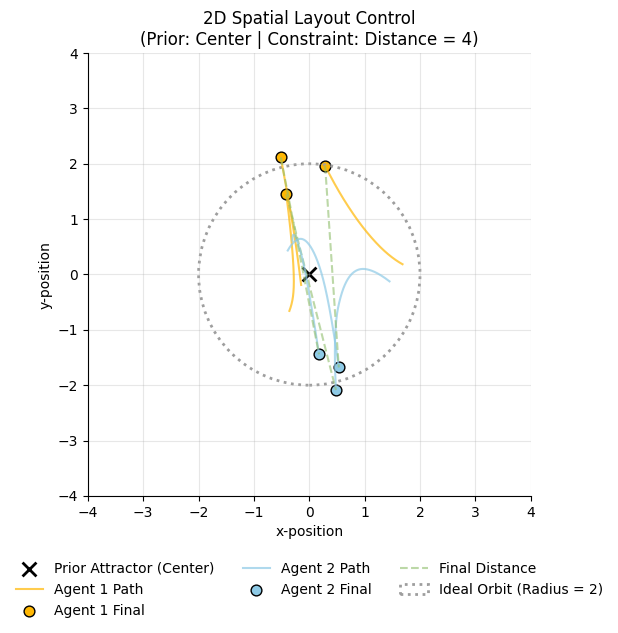

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.set_title("2D Spatial Layout Control\n(Prior: Center | Constraint: Distance = 4)")

# Pastel colors
color_a1 = "#ffb703"  # Agent 1 (orange)
color_a2 = "#8ecae6"  # Agent 2 (blue)
color_conn = "#90be6d"  # soft green for connections
color_ring = "#9e9e9e"  # grey for orbit

center = ax.scatter(0, 0, c="black", marker="x", s=100, linewidths=2)
path1 = path2 = final1 = final2 = conn_line = None

# Trajectories
n_agents = traj_x1.shape[0]
for k in range(n_agents):
    # Agent 1
    p1, = ax.plot(traj_x1[k, :, 0], traj_x1[k, :, 1],
                  c=color_a1, alpha=0.7, linewidth=1.5)
    f1 = ax.scatter(traj_x1[k, -1, 0], traj_x1[k, -1, 1],
                    c=color_a1, edgecolors="black", s=60)

    # Agent 2
    p2, = ax.plot(traj_x2[k, :, 0], traj_x2[k, :, 1],
                  c=color_a2, alpha=0.7, linewidth=1.5)
    f2 = ax.scatter(traj_x2[k, -1, 0], traj_x2[k, -1, 1],
                    c=color_a2, edgecolors="black", s=60)

    # Connection between final positions
    c_line, = ax.plot(
        [traj_x1[k, -1, 0], traj_x2[k, -1, 0]],
        [traj_x1[k, -1, 1], traj_x2[k, -1, 1]],
        c=color_conn, linestyle="--", alpha=0.6, linewidth=1.5
    )

    # save only once for legend
    if k == 0:
        path1, final1, path2, final2, conn_line = p1, f1, p2, f2, c_line

# Target ring (ideal orbit)
circle = plt.Circle((0, 0), 2.0, edgecolor=color_ring,
                    fill=False, linestyle=":", linewidth=2)
ax.add_patch(circle)

# Axes settings
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect("equal", "box")
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")

# Grid & spines
ax.grid(True, alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend at bottom
ax.legend(
    [center, path1, final1, path2, final2, conn_line, circle],
   [ 
        "Prior Attractor (Center)",
        "Agent 1 Path", "Agent 1 Final",
        "Agent 2 Path", "Agent 2 Final",
        "Final Distance",
        "Ideal Orbit (Radius = 2)",
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()